In [ ]:
!pip install census

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install us

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 10.9 MB/s 
  Created wheel for us: filename=us-2.0.2-py3-none-any.whl size=11945 sha256=26e8e2a83f0afa73312e0351c10260bf5ddabfaea680baade26e9434aa82af79
  Stored in directory: /root/.cache/pip/wheels/07/4c/fa/a65ed0f9c00360e785327fc370eba55ca575cc3508ab13ed8e
  Created wheel for jellyfish: filename=jellyfish-0.6.1-cp38-cp38-linux_x86_64.whl size=74768 sha256=ebbad2c532a1d88a41c03ea412467ebb8d3feba16603c082bd09506a951ea1db
  Stored in directory: /root/.cache/pip/wheels/aa/a9/a6/359d736dbeda356e6ab8a7ff70a3db636cefe91df7d09f63dc
Successfully built us jellyfish


In [ ]:
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 8.4 MB/s 
     |████████████████████████████████| 2.2 MB 42.4 MB/s 


In [ ]:
!pip install censusgeocode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
!pip install cenpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 11.5 MB/s 
     |████████████████████████████████| 1.0 MB 35.1 MB/s 
     |████████████████████████████████| 2.4 MB 50.1 MB/s 
     |████████████████████████████████| 16.6 MB 140 kB/s 
     |████████████████████████████████| 7.8 MB 45.7 MB/s 
  Created wheel for cenpy: filename=cenpy-1.0.1-py3-none-any.whl size=30061 sha256=8bf50c8369ef8996d6c87b67b605d0de9981725b1eae3de71a0db4b1eaa4cac5
  Stored in directory: /root/.cache/pip/wheels/ed/a3/b9/ec8f57828ca04f3e5035ad526fc7f4b22c61472e05d919b5af
Successfully built cenpy


In [ ]:
import pandas as pd
from google.colab import drive
import censusgeocode as cg
from cenpy import products
from us import states
from census import Census
from sklearn.linear_model import LinearRegression
from scipy.stats.mstats import winsorize
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

drive.mount('/content/drive')
pd.set_option("display.max_rows", None)
pd.set_option('max_columns', None)

Mounted at /content/drive


In [ ]:
turnstileDecThirdPath = '/content/drive/My Drive/Colab Notebooks/CYPLAN257 Final Project/turnstile_221203.txt'
#turnstileNovTwentySixthPath = '/content/drive/My Drive/Colab Notebooks/CYPLAN257 Final Project/turnstile_221126.txt'
stationInfoPath = '/content/drive/My Drive/Colab Notebooks/CYPLAN257 Final Project/DOITT_SUBWAY_STATION_01_13SEPT2010.csv'

Load files

In [ ]:
tstileDecThird = pd.read_csv(turnstileDecThirdPath, sep=',').rename(columns=lambda x: x.strip())
#tstileDecNovTwentySixth = pd.read_csv(turnstileNovTwentySixthPath, sep=',').rename(columns=lambda x: x.strip())
stationInfo = pd.read_csv(stationInfoPath)

Create a dataframe showing entries, exits, and traffic for each station and day covered by the data

In [ ]:
## gets the number of entries and exits
def getEntriesNExits(inputDF):
  #inspired by: https://towardsdatascience.com/mta-turstile-data-my-first-taste-of-a-data-science-project-493b03f1708a
  inputDF['DATE'] = pd.to_datetime(inputDF['DATE'],format="%m/%d/%Y")
  inputDF['TIME'] = pd.to_datetime(inputDF['TIME'],format="%X")
  mtaEntries = inputDF.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.max() - tstileDecThird.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.min()
  mtaExits = inputDF.groupby(['STATION','C/A','UNIT','SCP','DATE']).EXITS.max() - tstileDecThird.groupby(['STATION','C/A','UNIT','SCP','DATE']).EXITS.min()

  ## flattens the data
  mtaEntriesFlat = mtaEntries.reset_index()
  mtaExitsFlat = mtaExits.reset_index()

  mtaEntriesExits = pd.merge(mtaEntriesFlat, mtaExitsFlat, how='outer')

  ## append weekday and traffic column to dataset
  mtaEntriesExits['WEEKDAY'] = mtaEntriesExits['DATE'].dt.day_name()
  mtaEntriesExits['TRAFFIC'] = mtaEntriesExits['ENTRIES'] + mtaEntriesExits['EXITS']
  mtaEntriesExits['WEEKDAY_INDEX'] = mtaEntriesExits['DATE'].dt.weekday
  mtaEntriesExits = mtaEntriesExits[(mtaEntriesExits.ENTRIES < 20000) & (mtaEntriesExits.ENTRIES < 20000)]
  mtaByStation = mtaEntriesExits.groupby(['STATION','DATE','WEEKDAY', 'WEEKDAY_INDEX']).sum().reset_index()
  return mtaByStation

In [ ]:
ridership = getEntriesNExits(tstileDecThird).sort_values(by=['STATION','DATE','WEEKDAY_INDEX'])
oneDayRidership = ridership[ridership['DATE']=='2022-11-28'][['STATION','ENTRIES','EXITS','TRAFFIC']]

In [ ]:
oneDayRidership.head().sort_values('STATION')

,STATION,ENTRIES,EXITS,TRAFFIC
2,1 AV,7215,17310,24525
9,103 ST,11727,15369,27096
16,103 ST-CORONA,14072,20744,34816
23,104 ST,2488,1552,4040
30,110 ST,4686,7749,12435


Add station lat/longs to ridership data

In [ ]:
stationInfo['STATION'] = stationInfo['NAME'].str.upper()
#ave to av
stationInfo['STATION'] = stationInfo['STATION'].str.replace(' AVE',' AV',regex=False)
#remove numeric suffixes - th
stationInfo['HAS-TH'] = stationInfo['STATION'].str.find('TH') > 0
stationInfo['TH-SPLIT'] = stationInfo[stationInfo['HAS-TH'] == True]['NAME'].str.split(" ").str[0].str.split('th').str[0]
stationInfo['TH-SPLIT-NAME'] = stationInfo['TH-SPLIT']+" ST"
stationInfo['TH-REPLACE'] = stationInfo['TH-SPLIT'].str.isnumeric()
stationInfo.loc[stationInfo['TH-REPLACE']==True,'STATION'] = stationInfo['TH-SPLIT']+" ST"
#remove numeric suffixes - nd
stationInfo['HAS-ND'] = stationInfo['STATION'].str.find('ND') > 0
stationInfo['ND-SPLIT'] = stationInfo[stationInfo['HAS-ND'] == True]['NAME'].str.split(" ").str[0].str.split('nf').str[0]
stationInfo['ND-SPLIT-NAME'] = stationInfo['ND-SPLIT']+" ST"
stationInfo['ND-REPLACE'] = stationInfo['ND-SPLIT'].str.isnumeric()
stationInfo.loc[stationInfo['ND-REPLACE']==True,'STATION'] = stationInfo['ND-SPLIT']+" ST"
#remove numeric suffixes - rd
stationInfo['HAS-RD'] = stationInfo['STATION'].str.find('RD') > 0
stationInfo['RD-SPLIT'] = stationInfo[stationInfo['HAS-RD'] == True]['NAME'].str.split(" ").str[0].str.split('rd').str[0]
stationInfo['RD-SPLIT-NAME'] = stationInfo['RD-SPLIT']+" ST"
stationInfo['RD-REPLACE'] = stationInfo['RD-SPLIT'].str.isnumeric()
stationInfo.loc[stationInfo['RD-REPLACE']==True,'STATION'] = stationInfo['RD-SPLIT']+" ST"
#clean lat longs
stationInfo['the_geom'].str.replace('POINT (',"",regex=False)
stationInfo['long'] = stationInfo['the_geom'].str.replace("POINT (","",regex=False).str.replace(")","",regex=False).str.split(" ").str[0]
stationInfo['lat'] = stationInfo['the_geom'].str.replace("POINT (","",regex=False).str.replace(")","",regex=False).str.split(" ").str[1]
stationLoc = stationInfo[['STATION','long','lat']]
#drop duplicates
stationLoc = stationLoc.drop_duplicates(subset=['STATION'])

In [ ]:
#110 without any string cleaning on station names
#>>> after replaceing AVE with AV
#>>> after replacing TH with NULL
#183 after replacing ND and RD with NULL
df = pd.merge(oneDayRidership,stationLoc,on='STATION',how='inner').sort_values('STATION')

In [ ]:
dfRows = df.shape[0]

Get census outcomes for these 183 subway stops and link them to ridership

In [ ]:
df['TRACT'] = 'EMPTY'

for i in range(0,dfRows):
  x = df.iloc[i]['long']
  y = df.iloc[i]['lat']
  result = cg.coordinates(x, y)
  tract = result['Census Tracts'][0]['GEOID']
  df.at[i,'TRACT'] = tract

In [ ]:
c = Census("8303093e1907520364c6cd2275d03bc36f32a4d6")
#make starter DF with commute times
censusData = c.acs5dp.get('DP03_0025E', geo={'for': 'tract:*','in': 'state:{} county:*'.format(states.NY.fips)})
censusDataDF = pd.DataFrame(censusData)

#ref: https://api.lightcast.io/datasets/acs-indicators
outcomes = ["DP02_0001E", "DP02_0002E", "DP02_0002PE", "DP02_0004E", "DP02_0004PE", "DP02_0006E", "DP02_0006PE", "DP02_0010E", "DP02_0010PE", "DP02_0016E", "DP02_0017E", "DP02_0069E", "DP02_0070E", "DP02_0070PE", "DP02_0071E", "DP02_0072E", "DP02_0072PE", "DP02_0088E", "DP02_0094E", "DP02_0094PE", "DP02_0114E", "DP03_0018E", "DP03_0019E", "DP03_0019PE", "DP03_0020E", "DP03_0020PE", "DP03_0021E", "DP03_0021PE", "DP03_0022E", "DP03_0022PE", "DP03_0023E", "DP03_0023PE", "DP03_0024E", "DP03_0024PE", "DP03_0062E", "DP03_0088E", "DP03_0105E", "DP03_0119PE", "DP03_0129PE", "DP03_0135PE", "DP04_0001E", "DP04_0002E", "DP04_0002PE", "DP04_0003E", "DP04_0003PE", "DP04_0004E", "DP04_0005E", "DP04_0089E", "DP04_0134E", "DP05_0018E"]
for outcome in outcomes:
  newData = c.acs5dp.get(outcome, geo={'for': 'tract:*',
                       'in': 'state:{} county:*'.format(states.NY.fips)})
  newDataDF = pd.DataFrame(newData)
  censusDataDF = censusDataDF.merge(newDataDF,on=['state','county','tract'])

In [ ]:
censusDataDF['TRACT'] = censusDataDF['state'].astype(str) + censusDataDF['county'].astype(str) + censusDataDF['tract'].astype(str)
merged = censusDataDF.merge(df,on='TRACT',how='outer')

Predict without PCA

In [ ]:
train = merged[merged['TRAFFIC'].notnull()]
test_X = merged[merged['TRAFFIC'].notnull()==False].drop(columns=['STATION','ENTRIES','EXITS','TRAFFIC','long','lat','county','state','tract','TRACT'])
test_X = test_X.transform(lambda row: winsorize(row, limits=[0.01,0.01]))

In [ ]:
train_X = train.drop(columns=['STATION','TRAFFIC','ENTRIES','EXITS','state','county','tract','lat','long','TRACT'])
train_Y = train['TRAFFIC']

#inspired by: https://stackoverflow.com/questions/59182805/winsorize-within-groups-of-dataframe
train_X = train_X.transform(lambda row: winsorize(row, limits=[0.01,0.01]))
train_Y = train_Y.transform(lambda row: winsorize(row, limits=[0.01,0.01])).values

reg = LinearRegression().fit(train_X, train_Y)
print("R-Squared:",reg.score(train_X, train_Y))
test_Y = reg.predict(test_X)
pd.Series(test_Y<0).value_counts()

R-Squared: 0.5016453306644317


False    3902
True     1336
dtype: int64

Predict with PCA, no scaler

In [ ]:
pca_v1 = PCA(n_components=3)
train_X_PCA_v1 = pca_v1.fit_transform(train_X) 
test_X_PCA_v1 = pca_v1.fit_transform(test_X) 
reg_PCA_v1 = LinearRegression().fit(train_X_PCA_v1, train_Y)
print("R-Squared:",reg_PCA_v1.score(train_X_PCA_v1, train_Y))
test_Y_PCA_v1 = reg_PCA_v1.predict(test_X_PCA_v1)
pd.Series(test_Y_PCA_v1<0).value_counts()

R-Squared: 0.020234314773536877


False    5130
True      108
dtype: int64

Predict with PCA, plus scaler

In [ ]:
sc = StandardScaler()
X_scaled = sc.fit_transform(train_X)

pca_v2 = PCA(n_components=3)
train_X_PCA_v2 = pca_v2.fit_transform(X_scaled) 
test_X_PCA_v2 = pca_v2.fit_transform(test_X)
reg_PCA_v2 = LinearRegression().fit(train_X_PCA_v2, train_Y)
print("R-Squared:",reg_PCA_v2.score(train_X_PCA_v2, train_Y))
test_Y_PCA_v2 = reg_PCA_v2.predict(test_X_PCA_v2)
pd.Series(test_Y_PCA_v2<0).value_counts()

R-Squared: 0.21984382776379285


False    4814
True      424
dtype: int64

In [ ]:
#Census: number of workers 16 years and over who take public transportation to work
print(merged['TRAFFIC'].corr(merged['DP03_0021E']))
print(merged['ENTRIES'].corr(merged['DP03_0021E']))
print(merged['EXITS'].corr(merged['DP03_0021E']))

0.22070180549908353
0.23635563280247845
0.20858336978515454


Text(0.5, 1.0, 'Correlation Matrix of Census and Subway Ridership Data')

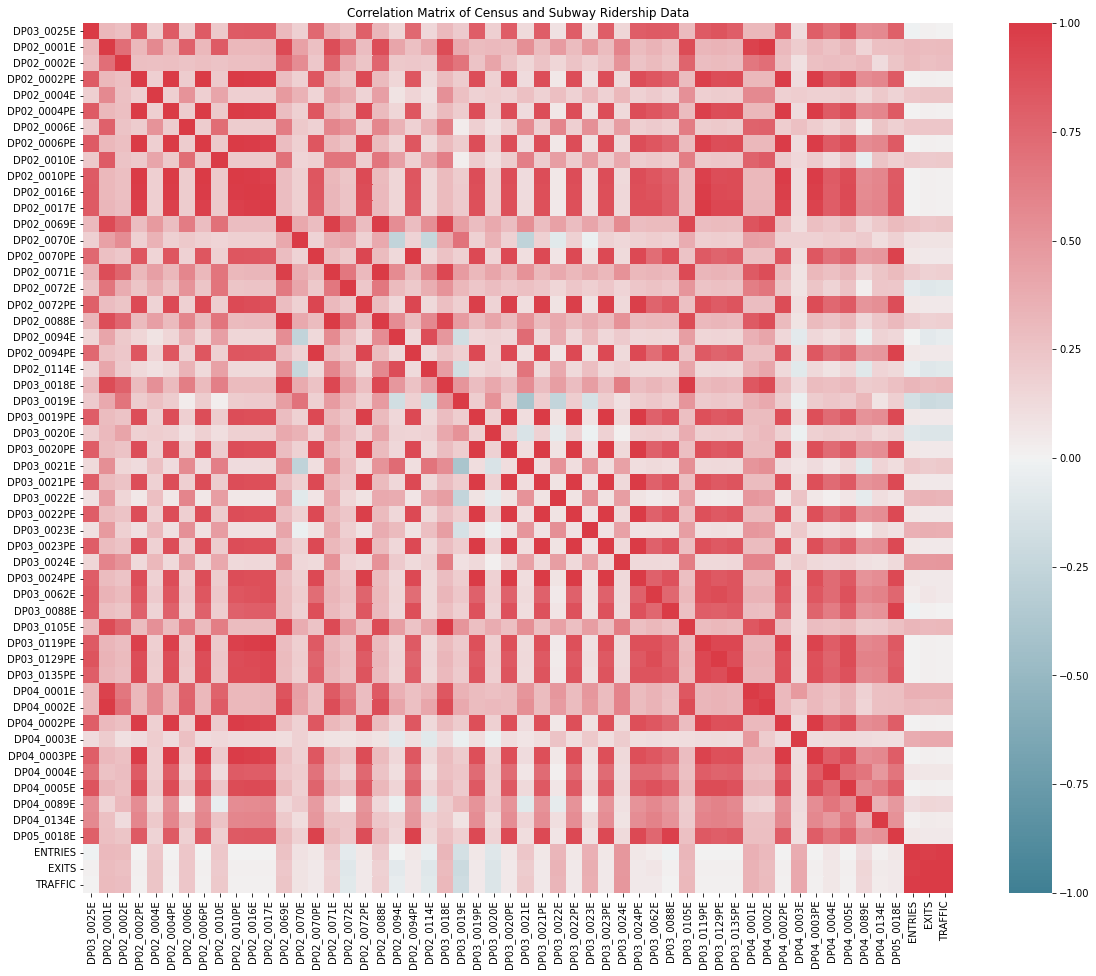

In [ ]:
f, ax = plt.subplots(figsize=(20, 16))
corr = merged.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
plt.title("Correlation Matrix of Census and Subway Ridership Data")

In [ ]:
#Census: 'work from home' as a means of transportation to work
print(merged['TRAFFIC'].corr(merged['DP03_0024E']))
print(merged['ENTRIES'].corr(merged['DP03_0024E']))
print(merged['EXITS'].corr(merged['DP03_0024E']))

0.493885184542695
0.4971917891583111
0.4860786758085529


Plot public transportation usage data from Census against subway stop locations

In [ ]:
nyc = products.ACS(2019).from_place('New York City, NY', level='tract',
                                        variables=['B08101_025E'])

/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


Matched: New York City, NY to New York city within layer Incorporated Places


/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
<ipython-input-27-e8e9c6fca95e>:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  nyc = products.ACS(2019).from_place('New York City, NY', level='tract',


In [ ]:
nyc.to_excel('/content/drive/My Drive/Colab Notebooks/CYPLAN257 Final Project/nyc_census.xlsx')

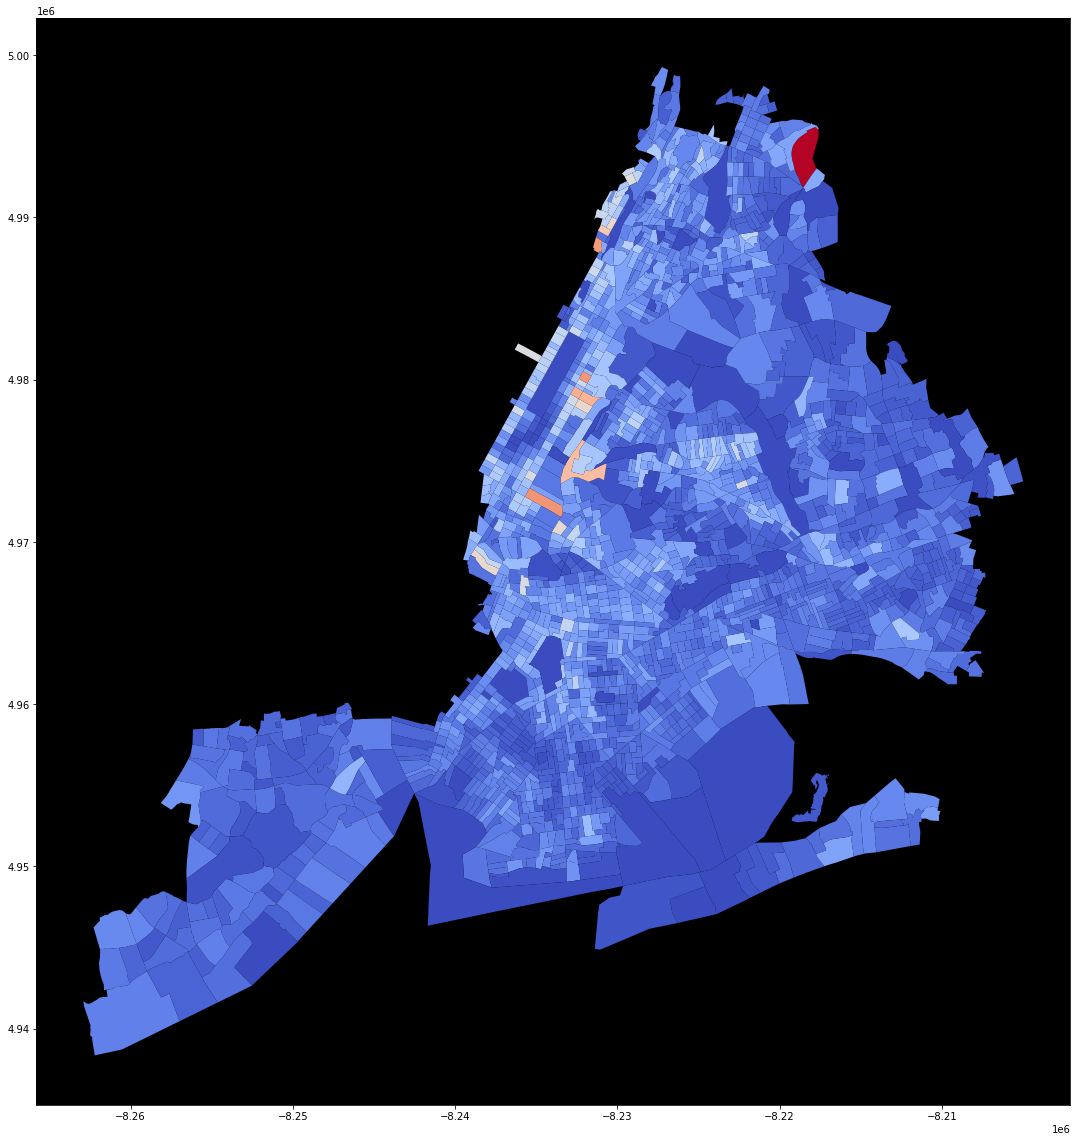

In [ ]:
f, ax = plt.subplots(1,1,figsize=(20,20))
nyc.dropna(subset=['B08101_025E'], axis=0).plot('B08101_025E', ax=ax, cmap='coolwarm')
ax.set_facecolor('k')

In [ ]:
#changing crs and exporting
nyc.to_crs("EPSG:2263").to_file('/content/drive/My Drive/Colab Notebooks/CYPLAN257 Final Project/nyc_reproj.shp')

<ipython-input-30-c58060a31fb3>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nyc.to_crs("EPSG:2263").to_file('/content/drive/My Drive/Colab Notebooks/CYPLAN257 Final Project/nyc_reproj.shp')


In [ ]:
nyc_pop = products.ACS(2019).from_place('New York City, NY', level='tract',
                                        variables=['B01001_001E'])
nyc_pop['pop_ratio'] = nyc_pop['B01001_001E']/nyc_pop.sum()[1]

/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


Matched: New York City, NY to New York city within layer Incorporated Places


/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
<ipython-input-41-18017c45ce28>:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  nyc_pop = products.ACS(2019).from_place('New York City, NY', level='tract',
<ipython-input-41-18017c45ce28>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  nyc_pop['pop_ratio'] = nyc_pop['B01001_001E']/nyc_pop.sum()[1]


In [ ]:
nyc_pop['log_pop_ratio'] = np.log(nyc_pop['pop_ratio'])

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32      False
33      False
34      False
35      False
36      False
37      False
38      False
39      False
40      False
41      False
42      False
43      False
44      False
45      False
46      False
47      False
48      False
49      False
50      False
51      False
52      False
53      False
54      False
55      False
56      False
57      False
58      False
59      False
60      False
61      False
62      False
63      False
64      False
65      False
66      False
67      False
68      False
69      False
70      False
71    

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:1025: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:1026: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


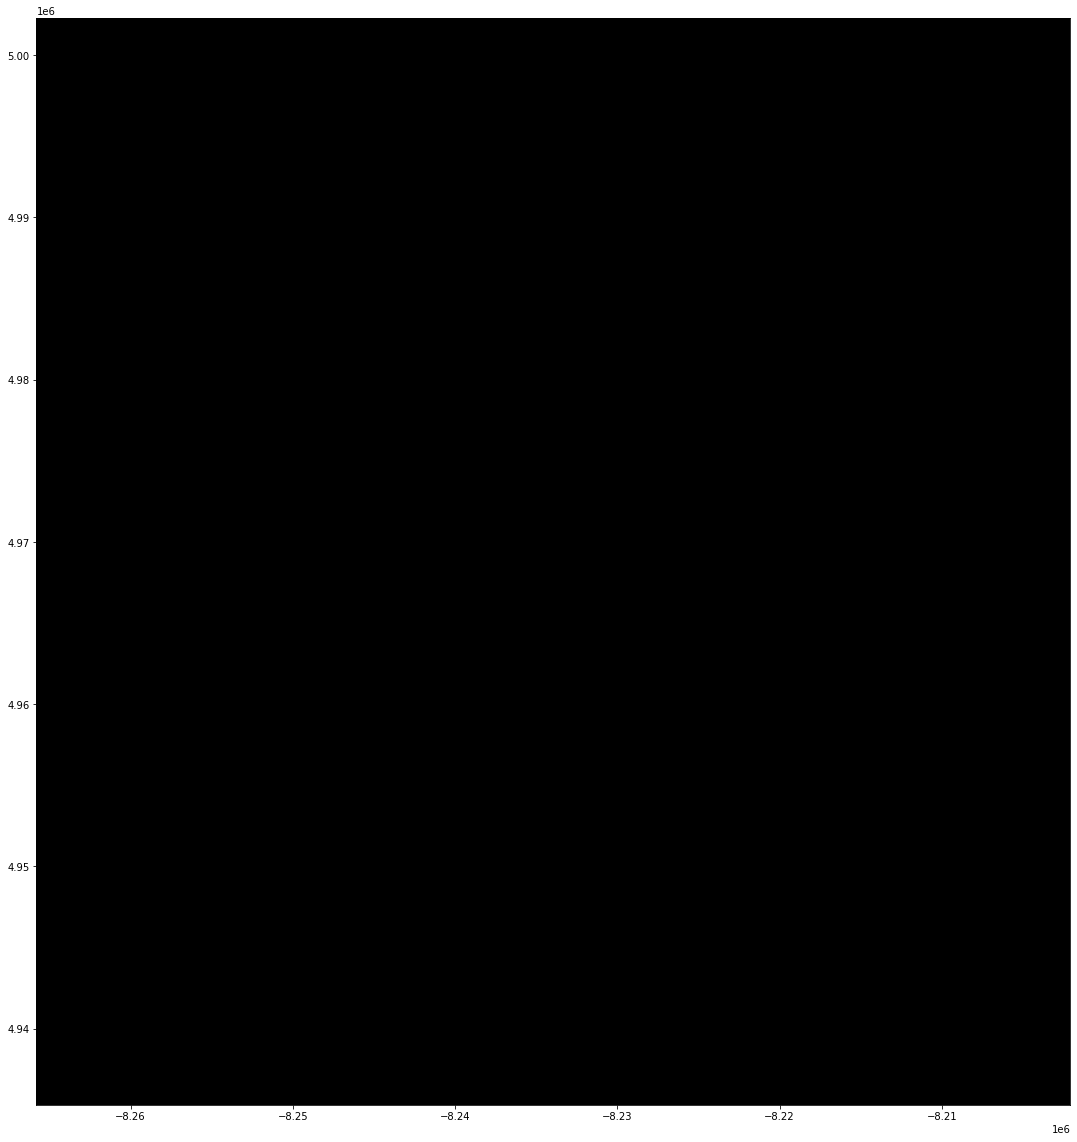

In [ ]:
f, ax = plt.subplots(1,1,figsize=(20,20))
nyc_pop.dropna(subset=['log_pop_ratio'], axis=0).plot('log_pop_ratio', ax=ax, cmap='coolwarm')
ax.set_facecolor('k')